c:\Users\namo\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\namo\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\namo\AppD

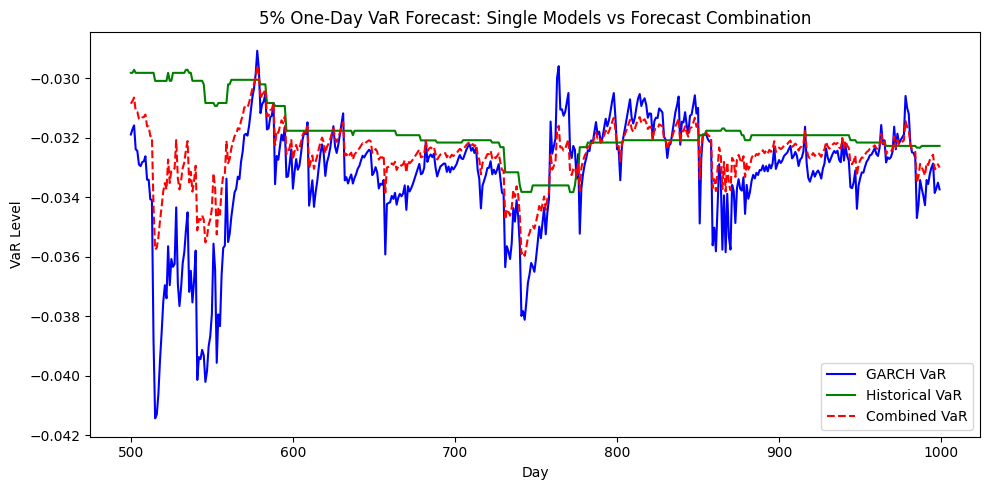

GARCH VaR violations: 23
Historical VaR violations: 30
Combined VaR violations: 26


In [1]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# --- Load Example Data (Daily Returns) ---
# Replace this with your actual financial returns data (e.g., S&P 500, FTSE)
# Example: Generating dummy returns for illustration
np.random.seed(420)
returns = np.random.normal(0, 0.02, 1000)  # 1000 days of synthetic returns
returns = pd.Series(returns)

# --- Define VaR confidence level ---
alpha = 0.05  # 5% VaR

# --- Simple Model 1: GARCH(1,1) VaR ---
garch = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch.fit(disp='off')

garch_var_list = []
for i in range(500, len(returns)):  # Rolling forecast starting from day 500
    rolling_data = returns[:i]
    model = arch_model(rolling_data, vol='Garch', p=1, q=1)
    result = model.fit(disp='off')
    forecast_var = result.forecast(horizon=1).variance.values[-1][0]
    garch_var = -1.65 * np.sqrt(forecast_var)  # For 5% one-day VaR
    garch_var_list.append(garch_var)

# --- Simple Model 2: Historical Simulation VaR ---
hist_var_list = []
window_size = 500
for i in range(window_size, len(returns)):
    hist_window = returns[i-window_size:i]
    hist_var = np.percentile(hist_window, 100 * alpha)  # 5% Historical VaR
    hist_var_list.append(hist_var)

# --- Forecast Combination: Simple Average of GARCH and Historical VaR ---
combined_var_list = []
for garch_v, hist_v in zip(garch_var_list, hist_var_list):
    combined_var = (garch_v + hist_v) / 2
    combined_var_list.append(combined_var)

# --- Compare VaR Forecasts ---
forecast_dates = np.arange(window_size, len(returns))
plt.figure(figsize=(10, 5))
plt.plot(forecast_dates, garch_var_list, label='GARCH VaR', color='blue')
plt.plot(forecast_dates, hist_var_list, label='Historical VaR', color='green')
plt.plot(forecast_dates, combined_var_list, label='Combined VaR', color='red', linestyle='--')
plt.title('5% One-Day VaR Forecast: Single Models vs Forecast Combination')
plt.xlabel('Day')
plt.ylabel('VaR Level')
plt.legend()
plt.tight_layout()
plt.show()

# --- Simple Backtesting: VaR Violations ---
actual_returns = returns[window_size:]

garch_violations = np.sum(actual_returns.values < np.array(garch_var_list))
hist_violations = np.sum(actual_returns.values < np.array(hist_var_list))
combined_violations = np.sum(actual_returns.values < np.array(combined_var_list))

print(f"GARCH VaR violations: {garch_violations}")
print(f"Historical VaR violations: {hist_violations}")
print(f"Combined VaR violations: {combined_violations}")

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def compute_var_es(returns, alpha=0.05, window=60):
    var_list, es_list = [], []
    for i in range(len(returns)):
        if i < window:
            var_list.append(np.nan)
            es_list.append(np.nan)
        else:
            window_returns = returns[i - window:i]
            var = np.quantile(window_returns, alpha)
            es = window_returns[window_returns < var].mean()
            var_list.append(var)
            es_list.append(es)
    return np.array(var_list), np.array(es_list)

def label_crisis_ci(returns, var):
    return (returns < var).astype(int)

def label_crisis_cei(returns, var, es, window=60):
    cei_labels = []
    for i in range(len(returns)):
        if i < window:
            cei_labels.append(0)
        else:
            recent = returns[i - window:i]
            tail_losses = recent[recent < var[i]]
            cei = 1 if tail_losses.mean() < es[i] else 0
            cei_labels.append(cei)
    return np.array(cei_labels)

def forward_label(crisis_indicator, forward_window=30):
    y = np.zeros_like(crisis_indicator)
    for t in range(len(crisis_indicator) - forward_window):
        if crisis_indicator[t+1:t+1+forward_window].max() == 1:
            y[t] = 1
    return y


In [3]:
# Sample returns
returns = pd.Series(np.random.normal(0, 0.01, 300))

# Compute VaR and ES
var, es = compute_var_es(returns, alpha=0.05, window=60)

# Get crisis labels
ci_label = label_crisis_ci(returns, var)
cei_label = label_crisis_cei(returns, var, es, window=60)

# Forward-looking early warning label
y_forward = forward_label(ci_label, forward_window=30)

In [4]:
import statsmodels.api as sm

# Feature: rolling volatility (e.g. 20-day std of returns)
vol = returns.rolling(20).std()

# Drop missing data
df = pd.DataFrame({
    "vol": vol,
    "label": y_forward
}).dropna()

# Fit logit model
X = sm.add_constant(df["vol"])
y = df["label"]
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.396042
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                  281
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.1542
Time:                        12:01:27   Log-Likelihood:                -111.29
converged:                       True   LL-Null:                       -131.58
Covariance Type:            nonrobust   LLR p-value:                 1.887e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7080      1.255     -4.550      0.000      -8.167      -3.249
vol          756.5737    135.

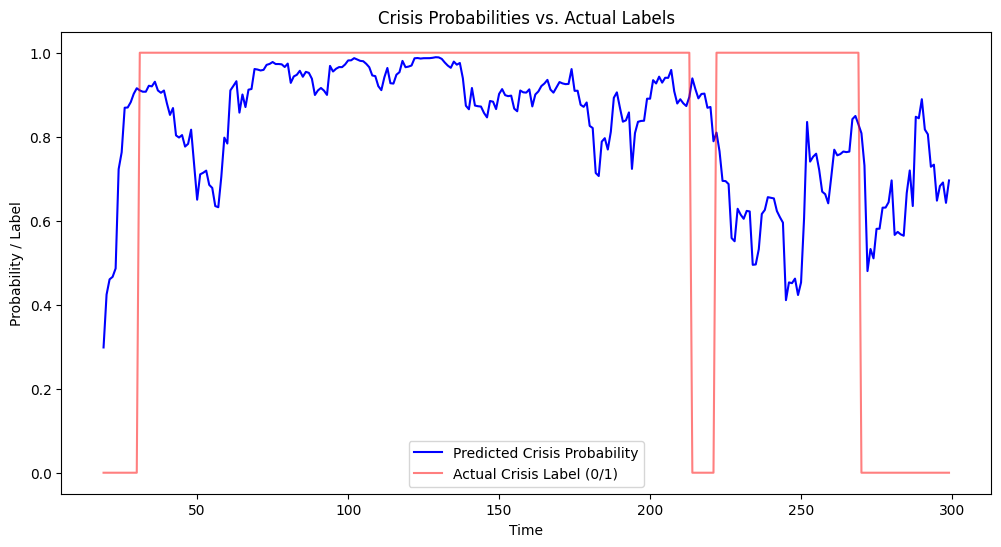

In [5]:
import matplotlib.pyplot as plt

# Predict probabilities
df["pred_prob"] = logit_model.predict(X)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["pred_prob"], label="Predicted Crisis Probability", color="blue")
plt.plot(df.index, df["label"], label="Actual Crisis Label (0/1)", color="red", alpha=0.5)
plt.legend()
plt.title("Crisis Probabilities vs. Actual Labels")
plt.xlabel("Time")
plt.ylabel("Probability / Label")
plt.show()
